In [2]:
import pandas as pd
import json

# Load IAM logs
with open('../data/iam_logs_sample.json') as f:
    data = json.load(f)

df = pd.DataFrame(data)
df.head()


,eventTime,userIdentity,eventName,sourceIPAddress,awsRegion,userAgent,responseElements,requestParameters
0,2024-12-01T12:00:00Z,alice,ListBuckets,192.168.1.10,us-west-2,aws-cli/2.7.0,Success,{}
1,2024-12-01T12:10:00Z,bob,CreateUser,192.168.1.23,us-east-1,aws-sdk-java,Success,{'userName': 'new_user'}
2,2024-12-01T12:20:00Z,eve,DeleteUser,10.0.0.5,ap-south-1,bot,Failed,{'userName': 'admin'}


In [8]:
import numpy as np
from sklearn.preprocessing import LabelEncoder


In [9]:
# Convert time to datetime
df['eventTime'] = pd.to_datetime(df['eventTime'])

# Extract numeric time features
df['hour'] = df['eventTime'].dt.hour
df['minute'] = df['eventTime'].dt.minute
df['timestamp'] = df['eventTime'].astype(np.int64) // 10**9


In [10]:
categorical_cols = ['userIdentity', 'eventName', 'sourceIPAddress', 'awsRegion', 'userAgent', 'responseElements']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le


In [11]:
df_engineered = df.drop(['eventTime', 'requestParameters'] + categorical_cols, axis=1)
df_engineered.head()


,hour,minute,timestamp,userIdentity_encoded,eventName_encoded,sourceIPAddress_encoded,awsRegion_encoded,userAgent_encoded,responseElements_encoded
0,12,0,1733054400,0,2,1,2,0,1
1,12,10,1733055000,1,0,2,1,1,1
2,12,20,1733055600,2,1,0,0,2,0


In [12]:
df_engineered.to_csv('../data/iam_logs_engineered.csv', index=False)


In [13]:
from sklearn.ensemble import IsolationForest


In [14]:
# Load the engineered data (if not already in memory)
df_model = pd.read_csv('../data/iam_logs_engineered.csv')

# Prepare feature matrix
X = df_model.copy()


In [15]:
# Train the model
model = IsolationForest(contamination=0.2, random_state=42)
model.fit(X)

# Predict anomalies
X['anomaly'] = model.predict(X)
X.head()


,hour,minute,timestamp,userIdentity_encoded,eventName_encoded,sourceIPAddress_encoded,awsRegion_encoded,userAgent_encoded,responseElements_encoded,anomaly
0,12,0,1733054400,0,2,1,2,0,1,1
1,12,10,1733055000,1,0,2,1,1,1,1
2,12,20,1733055600,2,1,0,0,2,0,1


In [16]:
X.to_csv('../data/iam_logs_with_anomaly.csv', index=False)


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
df_plot = pd.read_csv('../data/iam_logs_with_anomaly.csv')


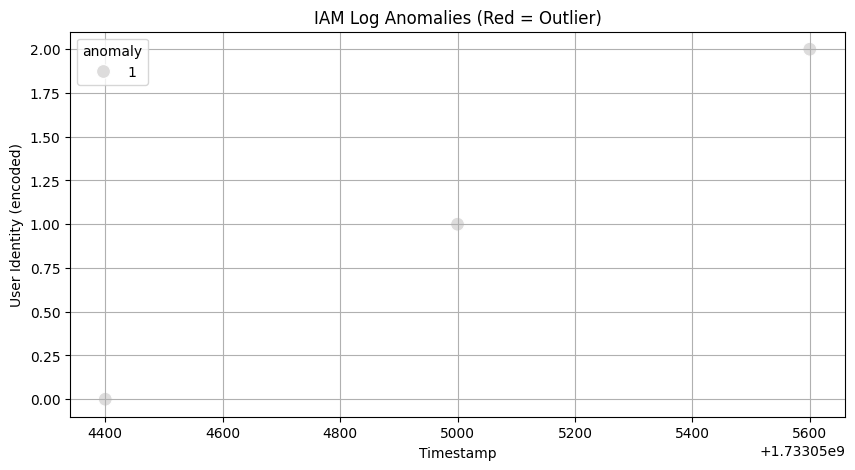

In [19]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=df_plot, x='timestamp', y='userIdentity_encoded', hue='anomaly', palette='coolwarm', s=100)
plt.title("IAM Log Anomalies (Red = Outlier)")
plt.xlabel("Timestamp")
plt.ylabel("User Identity (encoded)")
plt.grid(True)
plt.show()


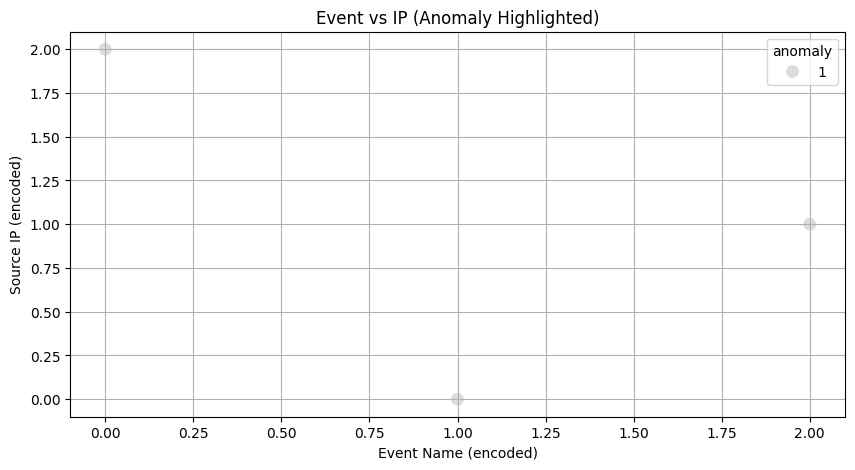

In [20]:
plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=df_plot,
    x='eventName_encoded',
    y='sourceIPAddress_encoded',
    hue='anomaly',
    palette='coolwarm',
    s=100
)
plt.title("Event vs IP (Anomaly Highlighted)")
plt.xlabel("Event Name (encoded)")
plt.ylabel("Source IP (encoded)")
plt.grid(True)
plt.show()
